# Graphene with a single adatom

In [1]:
import kwant
import tinyarray
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import product

FONT_LABELS = 20
# font = {'family' : 'serif', 'weight' : 'bold', 'size': FONT_LABELS}
font = {'size': FONT_LABELS}
mpl.rc('font', **font)
# plt.rc('text', usetex=True)

## Definition of the Graphene strip

Let's start by defining a system without SOC terms, but with two orbitals per site representing the spin. To do so, we've adopted the `general` lattice definition from `kwant.lattice` module. Such a function needs the primitive vectors and the coordinates of the basis atoms:

**Primitive vectors:**
* (1, 0)
* ($\sin 30°$, $\cos 30°$)

**Coordinates of basis atoms:**
* (0, 0)
* (0, $\frac{1}{\sqrt 3}$)

In [2]:
zeros_2x2 = tinyarray.array([[0,0],[0,0]])
sigma_0 = tinyarray.array([[1,0],[0,1]])
sigma_x = tinyarray.array([[0,1],[1,0]])
sigma_y = tinyarray.array([[0,-1j],[1j,0]])
sigma_z = tinyarray.array([[1,0],[0,-1]])

In [3]:
g_Lande = 2
Magneton_Bohr = 5.788e-5 # eV/T

In [4]:
class Rectangle:
    """
    Class to define callable objects to define the 
    shape of the scattering region of a rectangular
    system.
    """
    def __init__(self, W, L):
        '''
        Calling the scattering region as strip:
        W = width of the strip
        L = length of the strip 
        '''
        self.W = W
        self.L = L
        
    def __call__(self, pos):
        W, L = self.W, self.L
        x, y = pos
        return -W/2 < y < W/2 and -L/2 <= x <= L/2
    
    def leads(self, pos):
        W = self.W
        _, y = pos
        return -W/2 < y < W/2

### Builder functions:

With the inclusion of the magnetic field, we have to change the way the **on-site** and the **hoppings** are defined: both will be field and position dependent now. As we have been done so far, we'll change these aspects one-by-one adopting the code without magnetic field (located in notebook `randomly_positioned_adatoms`) as a template.

#### Zeeman effect

In [5]:
class Bfield:
    def __init__(self, Bvalue, Length_centered):
        self.Bvalue = Bvalue
        self.L = Length_centered
        
    def __call__(self, x, y):
        return self.Bvalue if np.abs(x) <= self.L/2 else 0 

In [6]:
def on_site_with_Zeeman(site, V, B, Lm):
    """
    This function defines the on-site energy by
    allowing to pass functions of position for
    the electrical potential and the magnetic field
    separately in order to account for the Zeeman
    effect.
    """
    x, y = site.pos
    Bfunc = Bfield(Bvalue=B, Length_centered=Lm)
    H_Z = g_Lande * Magneton_Bohr/2 * Bfunc(x,y) * sigma_z
    return V * sigma_0 + H_Z

def on_site_H_with_Zeeman(site, eps_H, B, Lm):
    """
    This function defines the on-site energy by
    allowing to pass functions of position for
    the electrical potential and the magnetic field
    separately in order to account for the Zeeman
    effect.
    """
    x, y = site.pos
    Bfunc = Bfield(Bvalue=B, Length_centered=Lm)
    H_Z = g_Lande * Magneton_Bohr/2 * Bfunc(x,y) * sigma_z
    return eps_H * sigma_0 + H_Z

#### Peierls subbstitution

In [7]:
## POSITION DEPENDENT HOPPINGS
def hopping_by_hand(Site1, Site2, t, B, Lm, peierls):
    return -t * sigma_0 * peierls(Site1, Site2, B, Lm)

def peierls_1(Site1, Site2, B, Lm):
    (x_i, y_i) = Site1.pos # Target
    (x_j, y_j) = Site2.pos # Source
    x_i, x_j = change_x(x_i, Lm), change_x(x_j, Lm)
    theta = B/2 * (x_i + x_j) * (y_i - y_j)
    return np.exp(-1j*theta)

def peierls_lead_L(Site1, Site2, B, Lm):
    (x_i, y_i) = Site1.pos # Target
    (x_j, y_j) = Site2.pos # Source
    theta = -B/2 * Lm * (y_i - y_j)
    return np.exp(-1j*theta)

def peierls_lead_R(Site1, Site2, B, Lm):
    (x_i, y_i) = Site1.pos # Target
    (x_j, y_j) = Site2.pos # Source
    theta = B/2 * Lm * (y_i - y_j)
    return np.exp(-1j*theta)

def change_x(x, Lm):
    if (-Lm/2) <= x <= (Lm/2): return x
    elif x > (Lm/2): return Lm/2
    else: return -Lm/2

In [8]:
class HoppingFunction(object):
    
    def __init__(self, B_0_hopping, sign):
        """
        This class helps to define the hoppings when there is a
        perpendicular magnetic field passing through the system.
        """
        self.B_0_hopping = B_0_hopping
        self.sign = sign
        
    def __call__(self, site1, site2, B, Lm, peierls):
        return self.sign * self.B_0_hopping * peierls(site1, site2, B, Lm)

In [9]:
def include_ISOC(system, G_sub_lattices, lambda_I=1):
    """
    ## INCLUDING THE INTRINSIC SOC (isoc):
    system         := kwant.builder.Builder
    G_sub_lattices := list of Graphene sublattices
    lambda_I       := parameter
    """
    sub_a, sub_b = G_sub_lattices
    # lambda_I   = 1 ## non-realistic; see reference: PRL 110, 246602 (2013)
    
    H_isoc_matrix = -1j/3 * lambda_I/np.sqrt(3) * sigma_z # counter-clockwise
    
    H_isoc_p = HoppingFunction(B_0_hopping=H_isoc_matrix, sign=+1)
    H_isoc_m = HoppingFunction(B_0_hopping=H_isoc_matrix, sign=-1)
    
    system[kwant.builder.HoppingKind((1,0), sub_a, sub_a)]  = H_isoc_p
    system[kwant.builder.HoppingKind((0,1), sub_a, sub_a)]  = H_isoc_m
    system[kwant.builder.HoppingKind((-1,1), sub_a, sub_a)] = H_isoc_p
    system[kwant.builder.HoppingKind((1,0), sub_b, sub_b)]  = H_isoc_p
    system[kwant.builder.HoppingKind((0,1), sub_b, sub_b)]  = H_isoc_p
    system[kwant.builder.HoppingKind((-1,1), sub_b, sub_b)] = H_isoc_m

In [10]:
def make_graphene_strip(lattice, scatter_shape, t=1, iso=1e-6):
    
    syst = kwant.Builder()
    syst[lattice.shape(scatter_shape, (0, 0))] = on_site_with_Zeeman  # this is a func. of Bfield and pos.

    # Specify the hoppings for graphene lattice in the
    # format expected by builder.HoppingKind
    a, b = lattice.sublattices
    hoppings_list = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    
#     hopping = t * sigma_0
    
    syst[[kwant.builder.HoppingKind(*hop) for hop in hoppings_list]] = hopping_by_hand
    syst.eradicate_dangling()
    
    include_ISOC(syst, [a,b], lambda_I=iso)
    
    return syst

In [11]:
def make_graphene_leads(lattice, lead_shape, t=1, on_site=0, iso=1e-6):
    a, b = lattice.sublattices
    symmetry = kwant.TranslationalSymmetry((-1,0))
    symmetry.add_site_family(a, other_vectors=[(-1,2)])
    symmetry.add_site_family(b, other_vectors=[(-1,2)])

    lead_0 = kwant.Builder(symmetry)
    lead_0[lattice.shape(lead_shape, (0,0))] = zeros_2x2

    hoppings_list = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
#     hopping = t * sigma_0
    lead_0[(kwant.builder.HoppingKind(*hop) for hop in hoppings_list)] = hopping_by_hand
    lead_0.eradicate_dangling()
    include_ISOC(lead_0, [a,b], lambda_I=iso)

    lead_1 = lead_0.reversed()
    
    lead_0 = lead_0.substituted(peierls='peierls_lead_L')
    lead_1 = lead_1.substituted(peierls='peierls_lead_R')

    return [lead_0, lead_1]

In [12]:
# Make the system
sin_30 = 1/2
cos_30 = np.sqrt(3)/2

graphene = kwant.lattice.general([(1, 0), (sin_30, cos_30)], # primitive vectors
                                 [(0, 0), (0, 1 / np.sqrt(3))],        # coord. of basis atoms
                                 norbs = 2,                            # number of orbitals per site (spin)
                                 name='Graphene'                       # name of identification
                                )
## Split in sublattices:
A, B = graphene.sublattices

## Define the shape of the system:
shape = Rectangle(W=10, L=50)

## Build the scattering region:
system = make_graphene_strip(graphene, shape, t=1, iso=1e-6)

## Make the leads:
leads  = make_graphene_leads(graphene, shape.leads, t=1, on_site=0, iso=1e-6)

## Attach the leads:
for lead in leads:
    system.attach_lead(lead)

In [13]:
# fsystem = system.finalized()

# parameters_wo_adatom_wo_B = dict(V=0,
#                        t=2.6,
#                        B=0.16,
#                        peierls=peierls_1,
#                        peierls_lead_L=peierls_lead_L,
#                        peierls_lead_R=peierls_lead_R,
#                        Lm=3,
#                     )

# spectrum = kwant.kpm.SpectralDensity(fsystem, params=parameters_wo_adatom_wo_B)
# # spectrum.add_moments(energy_resolution=0.03)


# energies, densities = spectrum()

# energies_subset = np.linspace(-1,1,201)
# densities_subset = spectrum(energies_subset)

# plt.plot(energies, densities.real)
# plt.plot(energies_subset, densities_subset.real)

In [14]:
# Colors for sites and hoppings
def family_colors(site):
    return 'w' if site.family == A else 'k' if site.family == B else 'r'

def hopping_colors(site1, site2):
#         if (site1.family==A and site1.family==site2.family) and (site1.tag == np.array([0,0]) or site2.tag == np.array([0,0])): # and site1.tag == np.array([0,0]) and site1.family==A:
#             color = 'red'
        if site1.family == site2.family:
            color='blue'
        else:
            color='black'
        return color

def hopping_lw(site1, site2):
    return 0.04 if site1.family == site2.family else 0.1

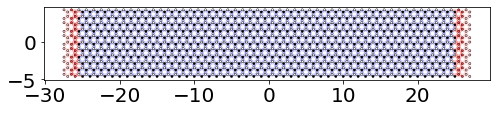

In [15]:
## Figure
fig, ax = plt.subplots(figsize=(8,8))
kwant.plot(system,
           site_color=family_colors,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
# ax.axis('off')
# ax.get_yaxis().set_ticklabels([])
# ax.get_xaxis().set_ticklabels([])
plt.show()

In [16]:
## Conductance
def calculate_conductance(syst, energy_values, params_dict):
    syst = syst.finalized()
    data = []
    for energy in energy_values:
        # compute the scattering matrix at a given energy
        smatrix = kwant.smatrix(syst, energy, params=params_dict)
        # compute the transmission probability from lead 0 to
        # lead 1
        data.append(smatrix.transmission(1, 0))
    return np.array(data)

In [17]:
# Calculate the transmission
parameters_wo_adatom_wo_B = dict(V=0,
                       t=1,
                       B=0,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=3,
                    )

parameters_wo_adatom_B = dict(V=0,
                       t=1,
                       B=0.05*np.pi,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=3,
                    )
energy_values = np.linspace(-2,2,300)
transmission0 = calculate_conductance(system, energy_values, params_dict=parameters_wo_adatom_wo_B)
transmission1 = calculate_conductance(system, energy_values, params_dict=parameters_wo_adatom_B)

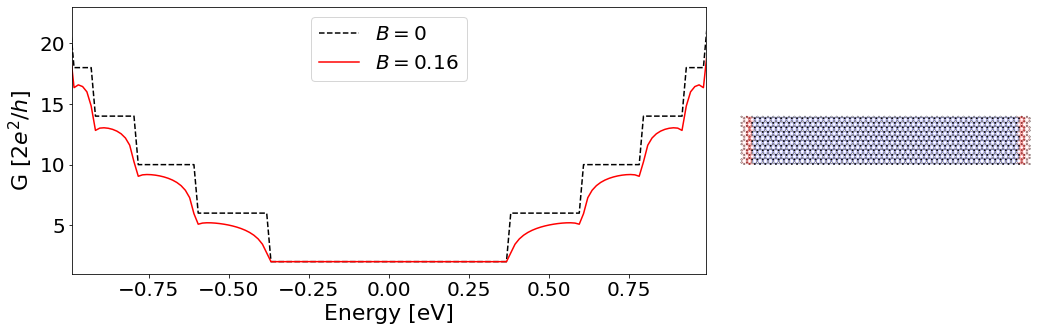

In [18]:
## Figure
fig, ax = plt.subplots(ncols=2,figsize=(15,5), gridspec_kw={'width_ratios':[2,1]})
kwant.plot(system,
           site_color=family_colors,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax[1])
ax[1].set_aspect('equal')
ax[1].axis('off')

ax[0].plot(energy_values, transmission0, c='k', label=r'$B = 0$', ls='--')
ax[0].plot(energy_values, transmission1, c='r', label=r'$B = {:.2f}$'.format(parameters_wo_adatom_B['B']))
ax[0].set_xlim(-.99,.99)
ax[0].tick_params(labelsize=20)
ax[0].set_xlabel("Energy [eV]", fontsize=22)
ax[0].set_ylabel("G $[2e^2/h]$", fontsize=22)
ax[0].legend(fontsize=20, loc=9)

plt.tight_layout()
# plt.savefig('conductance_wo_adatom_comparison_with_B.png', dpi=200)
plt.show()

## Placing the adatom and chaging the hopping properly

We want to place a single Hydrogen-atom on top of a specified Graphene site. As a criteria, we want to avoid the sites at the interface between the scattering system and the leads. Currently it is not possible to place an adatom at the boundaries of the strip, but it will be changed soon.

Since our system presents altered hoppings between next-nearest-neighbors, the sites allowed to host H-adatoms has to be at least one primitive vector away from the boundaries of the system. Now our tasks are, given the chosen C$_H$ atom (host Carbon atom),

1. to collect the nearest-neighbors (nn) and the next-nearest-neighbor (nnn) of C$_H$,
2. given the C$_H$, its nn and its nnn, to change the hoppings

### Defining the "pseudo-lattice" for H-atoms:

In [19]:
hydrogen = kwant.lattice.general([(1, 0), (sin_30, cos_30)], # primitive vectors
                                 [(0, 0), (0, 1 / np.sqrt(3))],        # coord. of basis atoms
                                 norbs = 2,                            # number of orbitals per site (spin)
                                 name='H'                              # name for identification
                                )
## Split in sublattices
HA, HB = hydrogen.sublattices

### Geetting the neighbors

In [20]:
## Getting the neighboring sites
def get_neighbors(system, C_H_site):
    site_tag = C_H_site.tag
    site_sub = C_H_site.family
    nn_list = get_nn(system, site_tag, site_sub)
    nnn_list = get_nnn(system, site_tag, site_sub)
    return nn_list, nnn_list

def get_nn(system, tag, sub_s):
    """
    system := kwant.builder.Builder
    tag    := tuple (i,j) of the site's tag
    sub_s  := site's sublattice

    Notice that
    """
    list_sub_lat = [A, B]
    list_sub_lat.remove(sub_s)
    sub_nn, = list_sub_lat
    # print(sub_nn.name[-1])
    name_indx = int(sub_s.name[-1])
    delta = +1 if name_indx == 0 else -1
    i,j = tag
    nn_tag_list = [(i,j), (i+delta,j-delta), (i,j-delta)]
    nn_sites = [
        sub_nn(*t) for t in nn_tag_list if sub_nn(*t) in system
    ]
    return nn_sites

def get_nnn(system, tag, sub_s):
    """
    system := kwant.builder.Builder
    tag    := tuple (i,j) of the site's tag
    sub_s  := site's sublattice

    Notice that
    """
    #sub_nnn = sub_s

    i,j = tag
    nnn_tag_list = [(  i,j+1), (i+1,  j),
                    (i+1,j-1), (  i,j-1),
                    (i-1,  j), (i-1,j+1)]
    nnn_sites = [
        sub_s(*t) for t in nnn_tag_list if sub_s(*t) in system
    ]
#     for site in nnn_sites:
#         print(site)
    return nnn_sites

### Induced SOC

$$
H_{ASO} = \frac{i}{3}\sum_{\langle\langle C_H, j \rangle\rangle} A^{\dagger}_{\sigma}c_{j,\sigma^{\prime}} \left[ \frac{\Lambda_I}{\sqrt{3}} \nu_{C_H, j} \hat{s}_z \right]_{\sigma, \sigma^{\prime}}
$$


$$
H_{BR} = \frac{2i}{3} \sum_{\langle C_H, j \rangle} A^{\dagger}_{\sigma}B_{j\sigma^{\prime}} \left[\Lambda_{BR} (\hat{s} \times \vec{d}_{C_H, j})_z\right]_{\sigma,\sigma^{\prime}}
$$

$$
H_{PIA} = \frac{2i}{3} \sum_{\langle\langle i,j \rangle\rangle} B^{\dagger}_{i\sigma}B_{j\sigma^{\prime}}[\Lambda_{PIA}(\hat{s}\times\vec{D}_{ij})_{z}]_{\sigma\sigma^{\prime}}
$$

[PRL 110, 246602 (2013)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.110.246602) 

In [21]:
## Changing the hoppings around the adatom
def include_ASO_sitewise(system, CH_site, NNN_site, Lambda_I=1):
    """
    Define and replace the hopping between CH_site and one of its NNN sites,
    which is identified here as NNN_site.
    """
    # 1.1. Identify the hopping 1/2
    delta_tag = list(NNN_site.tag - CH_site.tag)
    if delta_tag in ([0,1], [1,-1], [-1,0]): sign = -1
    else: sign = +1

    # 1.2. Identify the hopping 2/2
    family_id  = 1 - 2 * int(CH_site.family.name[-1]) ## 1 (-1) if sublattice == A (B)

    # 3. Define the hopping
    H_asoc_matrix = family_id * 1j/3 * Lambda_I/np.sqrt(3) * sigma_z # clockwise
    H_asoc = HoppingFunction(B_0_hopping=H_asoc_matrix, sign=sign)
    
    system[CH_site, NNN_site] = H_asoc

def include_BR_sitewise(system, CH_site, NN_site, t=1, Lambda_BR=1):
    """
    Update the hopping between the CH_site and the NN_site to include
    the Bychkov-Rashba SOC.
    """
    # 1. Identify the hopping 2/2:
    dx, dy = np.sqrt(3) * (CH_site.pos - NN_site.pos)
    
    
    
    H_hop_matrix = t * sigma_0
    H_BR_matrix = (2j/3) * Lambda_BR * (dy * sigma_x - dx * sigma_y) ## (S X d_ij)_z
    
    H_matrix = H_hop_matrix + H_BR_matrix
    
    H_BR = HoppingFunction(B_0_hopping = H_matrix, sign=+1)
    
    
    # 2. Define the hopping
    system[CH_site, NN_site] = H_BR

def include_PIA_sitewise(system, site_target, site_source, lambda_I=1, Lambda_PIA=1):
    """
    Define the PIA hopping and add to the already existent hopping between
    site_target and site_source.
    """
    # 1.1 Identify the hopping 1/2:
    Dx, Dy = site_target.pos - site_source.pos
    
    # 1.2 Identify the hopping 2/2:
    delta_tag = site_target.tag - site_source.tag
    
    # 2. ISO
    sites_family = site_target.family
    if sites_family == A and delta_tag in ([0,1], [1,-1], [-1,0]):
        H_iso_matrix = 1j/3 * lambda_I/np.sqrt(3) * sigma_z
    elif sites_family == B and delta_tag in ([0,-1], [-1,+1], [1,0]):
        H_iso_matrix = 1j/3 * lambda_I/np.sqrt(3) * sigma_z
    else:
        H_iso_matrix = -1j/3 * lambda_I/np.sqrt(3) * sigma_z

    # 3. PIA:
    H_PIA_matrix =  2j/3 * Lambda_PIA * (Dy * sigma_x - Dx * sigma_y) ## (S x D_ij)_z
    
    # 4. Total hopping:
    H_PIA_ISO = HoppingFunction(B_0_hopping = (H_iso_matrix + H_PIA_matrix), sign=+1) 
    
    system[site_target, site_source] = H_PIA_ISO

In [22]:
## Inserting adatom:
def insert_adatom(syst, pos_tag, sub_lat, t=1, l_iso=1, T=1, L_I=1, L_BR=1, L_PIA=1):
    if sub_lat == A:
        site_CH = A(*pos_tag)
        site_H = HA(*pos_tag)
    elif sub_lat == B:
        site_CH = B(*pos_tag)
        site_H = HB(*pos_tag)

    ## On-site:
    syst[site_H] = on_site_H_with_Zeeman
    ## Hopping:
    syst[site_H, site_CH] = T * sigma_0
    ## Neighbors
    nn_sites, nnn_sites = get_neighbors(syst, site_CH)

    ## Calculate and include the Adatom induced spin-orbit coupling
    for site in nnn_sites:
        include_ASO_sitewise(syst, site_CH, site, Lambda_I=L_I)

    ## Calculate and include into the system the Bychkov-Rashba spin-orbit coupling (BR)
    for site in nn_sites:
        include_BR_sitewise(syst, site_CH, site,t=t, Lambda_BR=L_BR)

    ## Calculate and include into the system the Pseudo-spin inversion asymmetry spin-orbit coupling (PIA)
    targets = [nn_sites[(i+1)%3] for i in range(3)]
    for site1, site2 in zip(targets, nn_sites):
        include_PIA_sitewise(syst, site1, site2, lambda_I=l_iso, Lambda_PIA=L_PIA)

In [23]:
pos_tag = (0,0)  # tag for the adatom
sub_lat = A      # sublattice of adatom
adatom_params = dict(t = 2.6, l_iso = 12e-6, T = 7.5, L_I = -0.21e-3, L_BR = 0.33e-3, L_PIA = -0.77e-3)

In [24]:
insert_adatom(system, pos_tag, sub_lat,  **adatom_params)

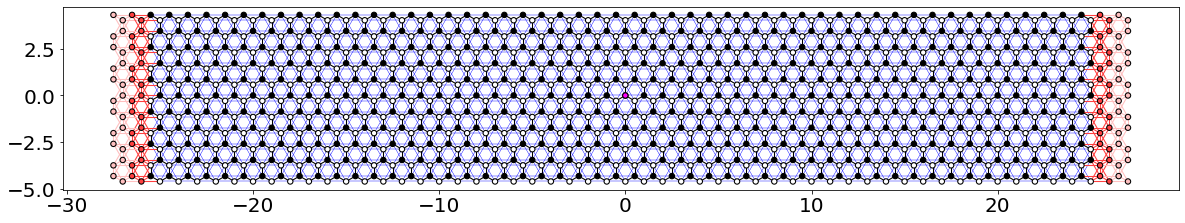

In [25]:
## System:
def family_colors(site):
        if site.family == A:
            color = 'k'
        elif site.family == B:
            color = 'w'
        elif site.family == HA:
            color = 'magenta'
        elif site.family == HB:
            color = 'magenta'
        else:
            color = 'magenta'
        return color

fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
plt.show()

In [26]:
fsystem = system.finalized()

parameters_wo_B = dict(V=0,
                       t=2.6,
                       B=0,
                       eps_H=0.16,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=3,
                    )

parameters_B = dict(V=0,
                       t=2.6,
                       B=0.05*np.pi,
                       eps_H=0.16,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=3,
                    )



center_tag = np.array([0, 0])
where = lambda s: s.tag == center_tag
# make local vectors
vector_factory = kwant.kpm.LocalVectors(fsystem, where)




spectrum = kwant.kpm.SpectralDensity(fsystem, params=parameters_wo_B, num_vectors=None,
                                          vector_factory=vector_factory,
                                          mean=False)
# spectrum.add_moments(100)
# spectrum.add_moments(energy_resolution=0.01)

# energies, densities = spectrum()

energies_subset = np.linspace(-2.2,2.2,501)
densities_subset = spectrum(energies_subset)

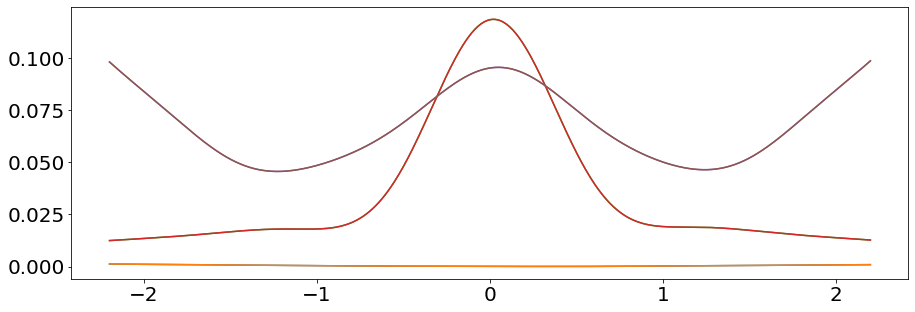

In [27]:
plt.figure(figsize=(15,5))
# plt.plot(energies, densities.real)
plt.plot(energies_subset, densities_subset.real)
# plt.ylim(1000, 7000)
# plt.xlim(-1.5, 1.5)

### Transport calculation

In [28]:
parameters_B = dict(V=0,
                       t=1,
                       B=0.05*np.pi,
                       eps_H=0.16,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=3,
                    )

parameters_wo_B = dict(V=0,
                       t=1,
                       B=0,
                       eps_H=0.16,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=3,
                    )

energy_values_2 = np.linspace(-1,1,300)
transmission2 = calculate_conductance(system, energy_values_2, params_dict=parameters_B)
transmission3 = calculate_conductance(system, energy_values_2, params_dict=parameters_wo_B)

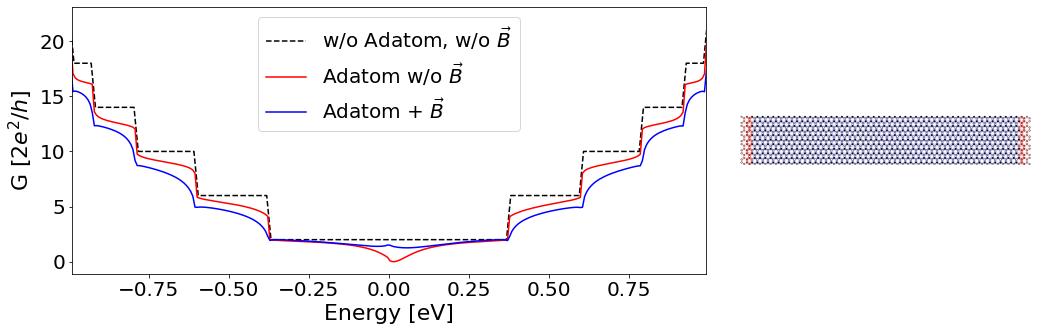

In [29]:
# Plot conductance
fig, ax = plt.subplots(ncols=2,figsize=(15,5), gridspec_kw={'width_ratios':[2,1]})
kwant.plot(system,
           site_color=family_colors,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax[1])
ax[1].set_aspect('equal')
ax[1].axis('off')

ax[0].plot(energy_values, transmission0, c='k', ls='--', label=r'w/o Adatom, w/o $\vec{B}$')
ax[0].plot(energy_values_2, transmission3, c='r', label=r'Adatom w/o $\vec{B}$')
ax[0].plot(energy_values_2, transmission2, c='b', label=r'Adatom + $\vec{B}$')
ax[0].set_xlim(-.99,.99)
ax[0].tick_params(labelsize=20)
ax[0].set_xlabel("Energy [eV]", fontsize=22)
ax[0].set_ylabel("G $[2e^2/h]$", fontsize=22)
ax[0].legend(fontsize=20, loc=9)

plt.tight_layout()
# plt.savefig('conductance_with_adatom_comparison_with_B_and_wo_adatom.png', dpi=200)
plt.show()

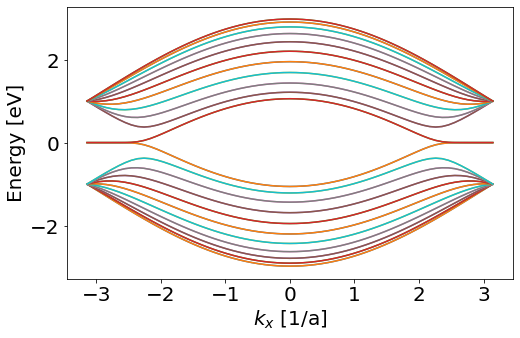

In [30]:
## L-Lead modes:
fig, ax = plt.subplots(figsize=(8,5))
params_lead_0_hand = dict(t=1,
                          B=0.5*np.pi,
                          peierls_lead_L=peierls_lead_L,
                          Lm=3,
                         )
lead_0 = leads[0].finalized()
kwant.plotter.bands(lead_0, params=params_lead_0_hand, ax=ax)
ax.set_ylabel('Energy [eV]')
ax.set_xlabel(r'$k_x$ [1/a]')
plt.savefig('energy_dispersion_left_lead.png', dpi=200)

In [31]:
# energy_values_2 = np.linspace(-1,1,301)
# transmission2 = calculate_conductance(system, energy_values_2, params_dict=parameters_B)
# transmission3 = calculate_conductance(system, energy_values_2, params_dict=parameters_wo_B)

## More than one Adatom:

In [32]:
## All tags in the system for sites of sublattice A:
first_component_tags_sublattice_A = np.unique([site.tag[0] for site in system.sites() if site.family==A])
second_component_tags_sublattice_A = np.unique([site.tag[1] for site in system.sites() if site.family==A])
print("First component of the tags for sublattice A sites : \n", first_component_tags_sublattice_A)
print("Second component of the tags for sublattice A sites : \n", second_component_tags_sublattice_A)

First component of the tags for sublattice A sites : 
 [-28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11
 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27]
Second component of the tags for sublattice A sites : 
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]


In [33]:
## All tags in the system for sites of sublattice B:
first_component_tags_sublattice_B = np.unique([site.tag[0] for site in system.sites() if site.family==B])
second_component_tags_sublattice_B = np.unique([site.tag[1] for site in system.sites() if site.family==B])
print("First component of the tag for sublattice B sites : \n",
      first_component_tags_sublattice_B)
print("Second component of the tag for sublattice B sites : \n",
      second_component_tags_sublattice_B)

First component of the tag for sublattice B sites : 
 [-27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10
  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8
   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27  28]
Second component of the tag for sublattice B sites : 
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4]


In [34]:
## Allowed sites:

# allowed_sites = []

# for site in system.sites():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-34-55a75ab71bcb>, line 6)

## Periodic Boundary Conditions

In [ ]:
parameters_wo_adatom_wo_B = dict(V=0,
                       t=2.6,
                       B=0.16,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=3,
                    )

parameters_B = dict(V=0,
                       t=2.6,
                       B=0.05*np.pi,
                       eps_H=0.16,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=3,
                    )

parameters_wo_B = dict(V=0,
                       t=2.6,
                       B=0,
                       eps_H=0.16,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=3,
                    )


In [ ]:
def make_graphene_strip_sym(lattice, scatter_shape, t=1, iso=1e-6):
    
    a, b = lattice.sublattices
    hoppings_list = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    
    sym = kwant.TranslationalSymmetry(lattice.vec((100, 0)), lattice.vec((0, 100)))
    
    anc = kwant.Builder(sym)
    anc[lattice.shape(scatter_shape, (0, 0))] = None
    anc[[kwant.builder.HoppingKind(*hop) for hop in hoppings_list]] = None
#     anc.eradicate_dangling()
    
    include_ISOC(anc, [a,b], lambda_I=iso)
    
    
#     syst = kwant.Builder()
#     syst[lattice.shape(scatter_shape, (0, 0))] = on_site_with_Zeeman  # this is a func. of Bfield and pos.

#     # Specify the hoppings for graphene lattice in the
#     # format expected by builder.HoppingKind
#     a, b = lattice.sublattices
#     hoppings_list = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    
# #     hopping = t * sigma_0
    
#     syst[[kwant.builder.HoppingKind(*hop) for hop in hoppings_list]] = hopping_by_hand
#     syst.eradicate_dangling()
    
#     include_ISOC(syst, [a,b], lambda_I=iso)
    
    
    
    
    sys = kwant.Builder()
    sys[anc.sites()] = on_site_with_Zeeman  # this is a func. of Bfield and pos.
    sys[((a, sym.to_fd(b)) for a, b in anc.hoppings())] = hopping_by_hand
    
    
    return sys

In [ ]:
system = make_graphene_strip_sym(graphene, shape, t=1, iso=1e-6)

In [ ]:
fsystem = system.finalized()
spectrum = kwant.kpm.SpectralDensity(fsystem, params=parameters_wo_adatom_wo_B)
# spectrum.add_vectors(500)

In [ ]:
energies_subset = np.linspace(-1.5,1.5,201)
densities_subset = spectrum(energies_subset)
energies, densities = spectrum()

In [ ]:
plt.plot(energies, densities.real)
plt.plot(energies_subset, densities_subset.real)

In [ ]:
kwant.plot(system)

## Getting the neighbors of the C_H's

To properly define the hoppings, we have to know where the adatoms are located and to keep track of its neighbors, the nearest (NN) and the next-nearest (NNN). It is important to pay attention to the situation in which the adatoms are placed on top of neighboring Carbon atoms. If the code are implemented in such a way that the different SOC contributions are added one-by-one, the hoppings between the neighbors $C_H$s might be updated wrongly, counting the same SOC contribution twice (or even more).

Let's do a brainstorm listing the steps required to define all hopping terms of the system:

1. Define the Graphene strip and the leads:
    - Carbon (C) atoms on-site energy
    - "A-B" hoppings (NN)
    - "A-A" and "B-B" hoppings (NNN) **ISO**
2. Place the H-adatoms:
    - Hydrogen atoms on-site ennergy
    - "H-C" hoppings
3. Get the neighbors of all the Carbon atom coupled to a H-atom ($C_H$):
    - Nearest-Neighbors (NN): different sublattices (for **BR** and **PIA**)
    - Next-Nearest-Neighbors (NNN): same sublattices (for **ASO**)
4. With the positions of $C_H$ and the their neighbors change the hoppings: **paying attention to duplicates**
    - List of $C_H$-sites
    - Two lists of neighbors for each of the $C_H$: NN's and NNN's.
    - **For each soc contribution** define a `list` or a `set` (updated pairs) on which we're going to put every pair of sites we have updated: The **PIA** pair of one site may form a NNN pair (**ASO**)  
    - Before changing the hopping verify if the pair of sites is already on the list.
    - Change the hoppings if the pair isn't in the list,...
    - ...then add the pair (site1,site2) and (site2,site1) on the list.  

In [ ]:
# for s in system.sites():
#     if s.family==HA or s.family==HB:
#         print(s.family.name)
#         print('tag = ', s.tag)
#         print('type(tag) = ', type(s.tag))
#         print(type(s.pos), end='\n\n')

In [ ]:
def get_CH(system, CH_sublattices, H_sublattices):
    """
    system := kwant.builder.Builder
    CH_sublattices := list of the graphene sublattices
    H_sublattices := list of H atoms sublattices
    """
    A, B = CH_sublattices
    HA, HB = H_sublattices
    
    list_CH = []
    
    for site in system.sites():
        if site.family == HA:
            list_CH.append(A(*site.tag))
        elif site.family == HB:
            list_CH.append(B(*site.tag))
    return list_CH

def get_neighbors(system, C_H_site, CH_sublattices):
    site_tag = C_H_site.tag
    site_sub = C_H_site.family
    nn_list = get_nn(system, site_tag, site_sub, CH_sublattices)
    nnn_list = get_nnn(system, site_tag, site_sub)
    return [nn_list, nnn_list]

def get_nn(system, tag, sub_s, list_sub_lat):
    """
    system := kwant.builder.Builder
    tag    := tuple (i,j) of the site's tag
    sub_s  := site's sublattice
    
    Notice that 
    """
    list_sub_lat.remove(sub_s)
    sub_nn, = list_sub_lat
    # print(sub_nn.name[-1])
    name_indx = int(sub_s.name[-1])
    delta = +1 if name_indx == 0 else -1
#     print(delta)
    i,j = tag
    nn_tag_list = [(i,j), (i+delta,j-delta), (i,j-delta)] 
    nn_sites = [
        sub_nn(*t) for t in nn_tag_list if sub_nn(*t) in system
    ]
#     for site in nn_sites:
#         print(site)
    return nn_sites
        
def get_nnn(system, tag, sub_s):
    """
    system := kwant.builder.Builder
    tag    := tuple (i,j) of the site's tag
    sub_s  := site's sublattice
    
    Notice that 
    """
    #sub_nnn = sub_s

    i,j = tag
    nnn_tag_list = [(  i,j+1), (i+1,  j),
                    (i+1,j-1), (  i,j-1),
                    (i-1,  j), (i-1,j+1)] 
    nnn_sites = [
        sub_s(*t) for t in nnn_tag_list if sub_s(*t) in system
    ]
#     for site in nnn_sites:
#         print(site)
    return nnn_sites

In [ ]:
CH_sites = get_CH(system, [A,B], [HA,HB])

for site in CH_sites:
    print(site)

In [ ]:
all_neighbors = [get_neighbors(system, CH, [A,B]) for CH in CH_sites]

all_NN_neighbors = [a[0] for a in all_neighbors]
all_NNN_neighbors = [a[1] for a in all_neighbors]


## Including the SOC terms induced by the adatoms

In [ ]:
def include_ASO_sitewise(system, CH_site, NNN_site, hop_list, Lambda_I=1):
    """
    This function has two effects:
        1. Define a hopping between CH_site and NNN_site
        2. Returns an updated hop_list
    
    Naturaly, the first effect occurs only in the case the hopping 
    isn't on the list. Otherwise the hopping will not be included and
    the hop_list will not be altered.
    """
    # 1. Verify if the hopping is duplicated
    if (CH_site, NNN_site) not in hop_list: 

        # 2.1. Identify the hopping 1/2
        delta_tag = list(NNN_site.tag - CH_site.tag)
        if delta_tag in ([0,1], [1,-1], [-1,0]): sign = -1
        else: sign = +1
        
        # 2.2. Identify the hopping 2/2
        family_id  = 1 - 2 * int(CH_site.family.name[-1]) ## 1 (-1) if sublattice == A (B)
        
        # 3. Define the hopping
        H_asoc = sign * family_id * 1j/3 * Lambda_I/np.sqrt(3) * sigma_z # clockwise    
        system[CH_site, NNN_site] = H_asoc ## sytem[sublat_1(target), sublat_2(source)]
        
#         peierls_1(Site1, Site2, B, Lm)
        
        # 4. Save pairs in hop_list
        hop_list.append((CH_site, NNN_site)) # (CH, NNN)
        hop_list.append((NNN_site, CH_site)) # (NNN, CH)
        
    return hop_list


def include_BR_sitewise(system, CH_site, NN_site, hop_list, Lambda_BR=1):
    """
    This function has two effects:
        1. Define a hopping between CH_site and NN_site
        2. Returns an updated hop_list
    
    The first effect occurs only in the case the hopping 
    isn't on the list. Otherwise the hopping will not be included and
    the hop_list will not be altered.
    """
    # 1. Verify if the hopping is duplicated
    if (CH_site, NN_site) not in hop_list:
        
        # 2. Identify the hopping 2/2:
        dx, dy = np.sqrt(3) * (CH_site.pos - NN_site.pos) 
        H_BR = (2j/3) * Lambda_BR * (dy * sigma_x - dx * sigma_y) ## (S X d_ij)_z 
        
        # 3. Define the hopping
        system[CH_site, NN_site] += H_BR
        
        # 4. Save pairs in hop_list
        hop_list.append((CH_site, NN_site)) # (CH, NNN)
        hop_list.append((NN_site, CH_site)) # (NNN, CH)
        
    return hop_list


def include_PIA_sitewise(system, site_target, site_source, hop_list, Lambda_PIA=1):
    """
    This function has two effects:
        1. Define a hopping between CH_site and NN_site
        2. Returns an updated hop_list
    
    The first effect occurs only in the case the hopping 
    isn't on the list. Otherwise the hopping will not be included and
    the hop_list will not be altered.
    """
    # 1. Verify if the hopping is duplicated
    if (site_target, site_source) not in hop_list:
        
        # 2. Identify the hopping:
        Dx, Dy = site_target.pos - site_source.pos
        
        # 3. Define the hopping
        H_PIA =  2j/3 * Lambda_PIA * (Dy * sigma_x - Dx * sigma_y) ## (S x D_ij)_z
        system[site_target, site_source] += H_PIA
        
        # 4. Save pairs in hop_list
        hop_list.append((site_target, site_source)) # (site1, site2)
        hop_list.append((site_source, site_target)) # (site2, site1)
        
    return hop_list

#### Adatom induced spin-orbit coupling (ASO)

In [ ]:
## Calculate and include the Adatom induced spin-orbit coupling
hop_list_ASO = []
for CH_site, NNN_sites in zip(CH_sites, all_NNN_neighbors):
    for NNN_site in NNN_sites:
#         print(CH_site,'--', NNN_site)
        include_ASO_sitewise(system, CH_site, NNN_site, hop_list_ASO, Lambda_I=1)

In [ ]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors_H,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
plt.show()

#### Bychkov-Rashba spin-orbit coupling (BR)

In [ ]:
## Calculate and include into the system the Bychkov-Rashba spin-orbit coupling (BR)
hop_list_BR = []
for CH_site, NN_sites in zip(CH_sites, all_NN_neighbors):
    print(len(NN_sites))
    for NN_site in NN_sites:
        print(NN_site)
        include_BR_sitewise(system, CH_site, NN_site, hop_list_BR, Lambda_BR=1)

In [ ]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors_H,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
plt.show()

### Pseudo-spin inversion asymmetry SOC (PIA)

In [ ]:
## Calculate and include into the system the Pseudo-spin inversion asymmetry spin-orbit coupling (PIA)
hop_list_PIA = []
for NN_sites in all_NN_neighbors:
    targets = [NN_sites[(i+1)%3] for i in range(3)]
    for site1, site2 in zip(targets, NN_sites):
        print(site1, '<--', site2)
        include_PIA_sitewise(system, site1, site2, hop_list_PIA, Lambda_PIA=1)

In [ ]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors_H,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
plt.show()

## Checking the hoppings

Since we have fixed the seed for both of the sampling processes (one for HA positions and other for HB positions), we can treat the specific hoppings and check if their values are correct. Let's focus on the hoppings surrounding or point towards the site at the position $x=0$ and $y=0$.

$$
[A_{00}, B_{0-1}] = t \begin{pmatrix} 1 & 0\\0 & 1 \end{pmatrix} + \Lambda_{BR} \left[ \frac{1}{3}\begin{pmatrix} 0 & i\\i & 0 \end{pmatrix} - \sqrt{3}\begin{pmatrix} 0 & 1\\-1 & 0 \end{pmatrix} \right]
$$

In [ ]:
print(system[A(0,0), B(0,-1)]) ## Has to be identical to the matrix above

In [ ]:
print(system[B(0,-1), A(0,0)]) ## Has to be the adjunt of the previous matrix

## Considerations:

The model wasn't thought to be used in a system with high concentration of H-atoms, the exercise here was good to see the difficulties to define such a system. The concentration aimed is something lower than 10% with very sparsed location for the H-atom: 1 H-atom for 10 C-atoms without overlap. From here, we have to address the following scenarios:

* Graphene with ISO
* Graphene + ISO + Adatom at the Center
* Graphene + ISO + Adatom at the Center + Magnetic Field
* Graphene + ISO + Adatom at the Center + Magnetic Field + Magnetic moment